In [126]:
import pandas as pd
import numpy as np
np.random.seed=0
import seaborn as sns
import matplotlib.pyplot as plt;


from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from scipy.stats import entropy
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier


from sklearn.metrics import confusion_matrix,accuracy_score,f1_score,precision_score,recall_score
from sklearn.tree import DecisionTreeRegressor
from sklearn import tree

import warnings
warnings.filterwarnings("ignore")


from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets


import logging
 
logging.basicConfig(filename='app.log',format='%(asctime)s - %(message)s', level=logging.INFO)

In [27]:
clf = LogisticRegression(random_state=0,multi_class='auto',solver='liblinear') 
gnb = GaussianNB()
sf=svm.SVC()
dt = DecisionTreeClassifier(random_state=0,max_depth=3)

In [129]:
def transition_matrix(chain,printed=False):
    n = 1+ max(chain)
    M = np.zeros((n,n))
    for (i,j) in zip(chain,chain[1:]):
        M[i][j] += 1
    for row in M:
        s = sum(row)
        if s > 0:
            row[:] = [f/s for f in row]
    if printed:
        print(M)
    logging.info("Transition Matrix Calculated")
    return pd.DataFrame(M)

In [130]:
def Steady_State(state,transition,steps,visualise=True):
    stateHist=state
    for x in range(steps):
        state=np.dot(state,P)
        stateHist=np.append(stateHist,state,axis=0)
    if visualise:
        v=pd.DataFrame(stateHist)
        v.plot()
        plt.show()
    logging.info("Steady State Calculated")
    return state

In [131]:
def crest_factor(x):
    return np.max(np.abs(x))/np.sqrt(np.mean(np.square(x)))

In [132]:
def build_features(time):
    X = pd.DataFrame()
    dayz=time.columns[time.columns.str.contains('Time')]
    for i in range(len(dayz)):
        signal=time[dayz[i]]


        X.loc[i,'Name']=dayz[i].split('_')[0]
        X.loc[i,'Order']=int(dayz[i].split('_')[1])

        #Time Domain

        X.loc[i,'Sum']=signal.sum()
        X.loc[i,'Mean']=signal.mean()
        X.loc[i,'Std']=signal.std()
        X.loc[i,'Max']=signal.max()
        X.loc[i,'Min']=signal.min()

        rms = np.sqrt(np.mean(signal**2))
        X.loc[i,'RMS']=rms


        X.loc[i,'Skew']=signal.skew()
        X.loc[i,'Kurtosis']=signal.kurtosis()
        X.loc[i,'Crest Factor'] = crest_factor(signal)
        X.loc[i,'Impulse Factor'] = (signal.max()) / ((abs(signal)).mean())
        X.loc[i,'Margin Factor'] = (signal.max()) / ((abs(signal)).mean()**2)
        logging.info("Time Domain Features Calculated")
        #Frequency Domain

        f = np.fft.fft(signal)
        f_real = np.real(f)

        X.loc[i,'F_domain_Mean']=f_real.mean()
        X.loc[i,'F_domain_Std']=f_real.std()
        X.loc[i,'F_domain_Max']=f_real.max()
        X.loc[i,'F_domain_Min']=f_real.min()
        X.loc[i,'F_domain_Crest_Factor'] = crest_factor(f_real)
        X.loc[i,'F_domain_Impulse_Factor'] = (f_real.max()) / ((abs(f_real)).mean())
        X.loc[i,'F_domain_Margin_Factor'] = (f_real.max()) / ((abs(f_real)).mean()**2)
        logging.info("Frequency Domain Features Calculated")
    return X


In [133]:
def chunk_it(df,suffix,chunk_size=13000):
    list_df = [df[i:i+chunk_size] for i in range(0,df.shape[0],chunk_size)]
    x=pd.DataFrame()
    for i in range(int(df.shape[0]/chunk_size)):
        x[suffix+'_'+str(i)]=list_df[i].values
        x.add_suffix(suffix)
    logging.info("Signal Chunked into Seconds")
    return x

In [134]:
def m2_converter(Path_name,Label,Machine_Num):
    time1=pd.read_csv(Path_name,sep=',',skiprows=7,index_col=0).reset_index()
    dayz=time1.columns[time1.columns.str.contains('Time')]
    ch=pd.DataFrame()
    for i in range(len(dayz)):
        signal=time1[dayz[i]]
        temp=chunk_it(signal,dayz[i])
        ch=pd.concat([temp,ch],axis=1)
  
    tablem=build_features(ch)
    tablem['label']=Label
    logging.info("Signal Ready for Classification")
    return tablem
  

In [135]:
def lab_break(table,Label,breakdowns,widget=True):
    if widget:
        table.loc[table[table['Name'].isin(breakdowns.value)].index,'label']=Label
    else:
        table.loc[table[table['Name'].isin(breakdowns)].index,'label']=Label
        
    return table

In [136]:
def benchmark(X_train,y_train,X_test,y_test,Case):
    gnb.fit(X_train, y_train)
    sf.fit(X_train,y_train)
    dt.fit(X_train,y_train)
    clf.fit(X_train, y_train)
    logging.info("Classification Models Trained")
    
    y_pred_lf = clf.predict(X_test)
    y_pred_gnb = gnb.predict(X_test)
    y_pred_svb = sf.predict(X_test)
    y_pred_dt=dt.predict(X_test)
    
    logging.info("States Predicted")
    
    score_table=pd.DataFrame(columns=['Case','Method','Accuracy','Precision','Recall','F1'])
    score_table.loc[0] = [Case,'Naive Bayes',accuracy_score(y_test,y_pred_gnb),precision_score(y_test,y_pred_gnb,average='weighted'),recall_score(y_test,y_pred_gnb,average='weighted'),f1_score(y_test,y_pred_gnb,average='weighted')]
    score_table.loc[1] = [Case,'Logistic Reg',accuracy_score(y_test,y_pred_lf),precision_score(y_test,y_pred_lf,average='weighted'),recall_score(y_test,y_pred_lf,average='weighted'),f1_score(y_test,y_pred_lf,average='weighted')]
    score_table.loc[2] = [Case,'Support Vector Machines',accuracy_score(y_test,y_pred_svb),precision_score(y_test,y_pred_svb,average='weighted'),recall_score(y_test,y_pred_svb,average='weighted'),f1_score(y_test,y_pred_svb,average='weighted')]
    score_table.loc[3] = [Case,'Decision Trees',accuracy_score(y_test,y_pred_dt),precision_score(y_test,y_pred_dt,average='weighted'),recall_score(y_test,y_pred_dt,average='weighted'),f1_score(y_test,y_pred_dt,average='weighted')]
    
    return score_table
  

In [114]:
table=m2_converter("11_1_Sol_TWF.csv",0,111)

In [18]:
breakdowns=widgets.SelectMultiple(
    options=table['Name'].unique(),
    #value=dayz.tolist()[0],
    
    description='Days',
    disabled=False,
    height='300px'
)
display(breakdowns)

SelectMultiple(description='Days', options=('Time.7', 'Time.6', 'Time.5', 'Time.4', 'Time.3', 'Time.2', 'Time.…

In [115]:
breakdowns.value

('Time.6', 'Time.4', 'Time.1')

In [118]:
breakdowne=('Time.6', 'Time.4', 'Time.1')

In [121]:
table=lab_break(table,1,breakdowne,widget=False)

In [123]:
table

,Name,Order,Sum,Mean,Std,Max,Min,RMS,Skew,Kurtosis,...,Impulse Factor,Margin Factor,F_domain_Mean,F_domain_Std,F_domain_Max,F_domain_Min,F_domain_Crest_Factor,F_domain_Impulse_Factor,F_domain_Margin_Factor,label
0,Time.7,0.0,-27.562196,-0.002120,4.391805,12.902319,-13.342175,4.391637,0.021834,-0.280848,...,3.642127,1.028117,1.076923,246.080173,13183.233365,-2613.912554,53.572407,258.470073,5.067556,0
1,Time.7,1.0,78.101798,0.006008,4.348881,13.855806,-13.071939,4.348718,0.037153,-0.231213,...,3.971628,1.138427,6.121032,298.150312,13494.718070,-13542.775889,45.413076,234.420287,4.072176,0
2,Time.7,2.0,-43.446836,-0.003342,4.305248,13.284081,-12.835764,4.305083,0.023850,-0.210156,...,3.844797,1.112795,-2.804359,425.320166,5325.870430,-28862.909367,67.860130,86.851264,1.416321,0
3,Time.7,3.0,-24.380106,-0.001875,4.380967,13.707991,-13.027143,4.380799,0.046655,-0.272234,...,3.883471,1.100187,-13.027143,334.093004,3675.311397,-20458.894979,61.190625,66.949688,1.219559,0
4,Time.7,4.0,70.489402,0.005422,4.313482,13.691302,-14.035998,4.313320,0.047752,-0.210494,...,3.957206,1.143754,1.005203,292.105796,13893.603926,-9265.572196,47.563321,230.779067,3.833345,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75,Time,5.0,348.379441,0.026798,0.661311,2.928998,-4.252432,0.661828,-0.564656,6.011608,...,6.996580,16.712927,1.349332,52.858200,869.131145,-1110.694007,21.005867,90.301464,9.382191,0
76,Time,6.0,-540.717448,-0.041594,0.757238,2.373073,-2.778244,0.758351,0.044809,-0.226178,...,3.816661,6.138413,0.673320,67.465606,2633.150756,-1919.506363,39.027585,241.615935,22.170497,0
77,Time,7.0,-758.718372,-0.058363,2.199015,11.655925,-7.993203,2.199705,1.350041,4.175627,...,7.859737,5.299919,-0.009884,194.336244,8574.328709,-6876.617780,44.121099,418.551092,20.431339,0
78,Time,8.0,1025.620661,0.078894,0.408351,1.252565,-0.849863,0.415887,0.126469,-0.831205,...,3.567441,10.160454,0.497975,33.637382,1025.620661,-2171.032412,64.535181,238.638382,55.525673,0


In [124]:
names=table['Name'].values
table.drop('Name',axis=1,inplace=True)


X=table.copy()
X.drop('label',axis=1,inplace=True)
y=table['label'].values

In [125]:
X

,Order,Sum,Mean,Std,Max,Min,RMS,Skew,Kurtosis,Crest Factor,Impulse Factor,Margin Factor,F_domain_Mean,F_domain_Std,F_domain_Max,F_domain_Min,F_domain_Crest_Factor,F_domain_Impulse_Factor,F_domain_Margin_Factor
0,0.0,-27.562196,-0.002120,4.391805,12.902319,-13.342175,4.391637,0.021834,-0.280848,3.038087,3.642127,1.028117,1.076923,246.080173,13183.233365,-2613.912554,53.572407,258.470073,5.067556
1,1.0,78.101798,0.006008,4.348881,13.855806,-13.071939,4.348718,0.037153,-0.231213,3.186182,3.971628,1.138427,6.121032,298.150312,13494.718070,-13542.775889,45.413076,234.420287,4.072176
2,2.0,-43.446836,-0.003342,4.305248,13.284081,-12.835764,4.305083,0.023850,-0.210156,3.085673,3.844797,1.112795,-2.804359,425.320166,5325.870430,-28862.909367,67.860130,86.851264,1.416321
3,3.0,-24.380106,-0.001875,4.380967,13.707991,-13.027143,4.380799,0.046655,-0.272234,3.129107,3.883471,1.100187,-13.027143,334.093004,3675.311397,-20458.894979,61.190625,66.949688,1.219559
4,4.0,70.489402,0.005422,4.313482,13.691302,-14.035998,4.313320,0.047752,-0.210494,3.254106,3.957206,1.143754,1.005203,292.105796,13893.603926,-9265.572196,47.563321,230.779067,3.833345
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75,5.0,348.379441,0.026798,0.661311,2.928998,-4.252432,0.661828,-0.564656,6.011608,6.425279,6.996580,16.712927,1.349332,52.858200,869.131145,-1110.694007,21.005867,90.301464,9.382191
76,6.0,-540.717448,-0.041594,0.757238,2.373073,-2.778244,0.758351,0.044809,-0.226178,3.663535,3.816661,6.138413,0.673320,67.465606,2633.150756,-1919.506363,39.027585,241.615935,22.170497
77,7.0,-758.718372,-0.058363,2.199015,11.655925,-7.993203,2.199705,1.350041,4.175627,5.298859,7.859737,5.299919,-0.009884,194.336244,8574.328709,-6876.617780,44.121099,418.551092,20.431339
78,8.0,1025.620661,0.078894,0.408351,1.252565,-0.849863,0.415887,0.126469,-0.831205,3.011794,3.567441,10.160454,0.497975,33.637382,1025.620661,-2171.032412,64.535181,238.638382,55.525673


In [23]:
X_train, X_test, y_train, y_test = train_test_split(X.values, y, test_size=0.25, random_state=58)

In [28]:
benchmark(X_train,y_train,X_test,y_test,"Base")

,Case,Method,Accuracy,Precision,Recall,F1
0,Base,Naive Bayes,0.70,0.812500,0.70,0.670330
1,Base,Logistic Reg,0.65,0.664835,0.65,0.641944
2,Base,Support Vector Machines,0.55,0.566667,0.55,0.520000
3,Base,Decision Trees,0.70,0.738095,0.70,0.687500


In [34]:
table['label'].unique()

array([0, 1])

# Markov Chain Approach


In [74]:
mark=np.random.randint(4, size=len(table))

In [97]:
P=transition_matrix(mark)

In [105]:
state=np.array([[0.3, 0.2, 0.1,0.4]])


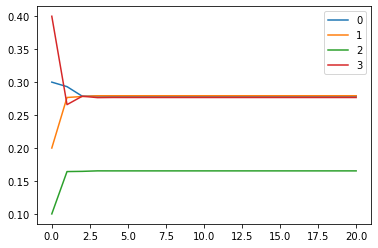

array([[0.27867424, 0.27933956, 0.16530792, 0.27667829]])

In [106]:

Steady_State(state,P,20)